## Import data

This notebook creates X's (Inputs) and Y's (Targets) used to test an implementation
of a Neural Network to be created by INDEX_NN.ipynb.  Specifically, Moscow and Tokyo index data are processed
as inputs.  The Nasdaq data is used as the target data.


INDEX_NN is to be trained on this data (spanning dates 1/1/15 thru 4/30/19)
INDEX_NN.ipynb then divides this data created by INPUT.ipynb into 3 parts:  Training, Dev and Test.



In [70]:
%autosave 0  
import os
print(os.getcwd()) 

from collections import Counter
from datetime import datetime
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
np.set_printoptions(threshold=np.inf)


Autosave disabled
C:\REPOS\playground_local_files\notebooks


In [39]:
# Set to true if you want to include volume data
include_volume=True

# Selects which set of indices to use as input - See next cell for selections
Input_Source = 'TwoIndices'      # Options:  Tier1,  Tier1_VIX, Tier2, Test, Playground
Target_Source='NSDQ'             # Options:  DOW30, NSDQ, SP500

DATA_PATH = './'
TARGET_PATH = './'

In [40]:
INPUT_INDEXES = ['LONDON', 'TOKYO']
    
# INPUTS is a List of Dictionaries
INPUTS = [{'label': 'LONDON', 'path': './London.csv'},
          {'label': 'TOKYO', 'path': './Tokyo.csv'}
    ]

TARGET = {'label': 'NSDQ', 'path': 'NSDQ.csv'}


Import input data..

In [42]:
# Store NN INDEX input data into `input_df` (input DataFrame)
# `input_df` is actually a dictionary storing multiple DataFrames for each input file

input_df = {}

    #  For each dictionary in INPUTS (iterator)... read the associated .csv file, returns it in a dataframe - store it in 
    # the dictionary input_df
for input_ in INPUTS:
    #input_ is a dictionary
    #print("dict:  ", input_)
    
    print('Importing data for: %s' % input_['label'])
    print(input_['path'])
        
    # read contents of the .csv file pointed to by input_
    # returned dataframe is stored in the dictionary input_df
    input_df[input_['label']] = pd.read_csv(os.path.join(DATA_PATH, input_['path']), dtype = str)

    print(input_df[input_['label']])
 
    

Importing data for: LONDON
./London.csv
           Date     Price      Open      High       Low     Vol. Change %
0     02-Jan-15  6,547.80  6,566.09  6,607.89  6,510.60  378.93M   -0.28%
1     05-Jan-15  6,417.16  6,547.80  6,576.74  6,404.49  750.52M   -2.00%
2     06-Jan-15  6,366.51  6,417.16  6,452.66  6,328.59  793.26M   -0.79%
3     07-Jan-15  6,419.83  6,366.51  6,459.74  6,366.51  709.50M    0.84%
4     08-Jan-15  6,569.96  6,419.83  6,580.82  6,419.83  910.04M    2.34%
5     09-Jan-15  6,501.14  6,569.96  6,570.24  6,471.38  761.33M   -1.05%
6     12-Jan-15  6,501.42  6,501.14  6,542.43  6,447.91  620.94M    0.00%
7     13-Jan-15  6,542.20  6,501.42  6,558.83  6,465.19  694.41M    0.63%
8     14-Jan-15  6,388.46  6,542.20  6,542.20  6,353.65    1.00B   -2.35%
9     15-Jan-15  6,498.78  6,388.46  6,498.78  6,298.15    1.01B    1.73%
10    16-Jan-15  6,550.27  6,498.78  6,553.20  6,443.28  830.66M    0.79%
11    19-Jan-15  6,585.53  6,550.27  6,598.89  6,548.00  554.55M    0.54

Import targets..

In [43]:
# Store the target data into `target_df` (target DataFrame)

print(TARGET['path'])

target_df = pd.read_csv(os.path.join(TARGET_PATH, TARGET['path']), dtype = str)
# target_df = pd.read_csv(TARGET['path'])

print(target_df)

NSDQ.csv
           Date     Price      Open      High       Low     Vol. Change %
0     02-Jan-15  4,726.81  4,760.24  4,777.01  4,698.11  367.74M   -0.20%
1     05-Jan-15  4,652.57  4,700.34  4,702.77  4,641.46  476.45M   -1.57%
2     06-Jan-15  4,592.74  4,666.85  4,667.33  4,567.60  553.62M   -1.29%
3     07-Jan-15  4,650.47  4,626.84  4,652.72  4,613.90  482.51M    1.26%
4     08-Jan-15  4,736.19  4,689.54  4,741.38  4,688.02  548.10M    1.84%
5     09-Jan-15  4,704.07  4,744.47  4,744.71  4,681.24  430.67M   -0.68%
6     12-Jan-15  4,664.71  4,714.07  4,715.81  4,650.65  491.28M   -0.84%
7     13-Jan-15  4,661.50  4,708.74  4,751.34  4,624.28  566.52M   -0.07%
8     14-Jan-15  4,639.32  4,610.76  4,655.37  4,595.98  527.38M   -0.48%
9     15-Jan-15  4,570.82  4,657.46  4,663.96  4,567.39  525.69M   -1.48%
10    16-Jan-15  4,634.38  4,566.38  4,635.82  4,563.11  548.60M    1.39%
11    20-Jan-15  4,654.85  4,655.84  4,665.65  4,601.10  473.62M    0.44%
12    21-Jan-15  4,667.42  4,

## Clean the Data

All data in the dataframes is strings. Excluding the `Date` column, all others need to be converted into floats, while `Date` needs to be converted to a `datetime` object. These columns need to be cleaned of the comma signs. Percentage signs should be removed from the `Change %` column and values in the `Vol.` column should be cleaned of the "M" and "B" letters denoting millions and billions, respectively. The `Date` column needs to be set as index to the tables, and column names `Vol.` and `Change %` need to be renamed to `Vol` and `Change` respectively.

Missing data in the `Vol.` column (such as in MOEX, RTSI and TA35) will be replaced by 0s. Let's see if the neural net will be able to capture that 0s represent missing data.

In [44]:
def set_date_as_index(df):
    '''
    Converts the `Date` column into datetime objects and sets it as index (more suitable for plotting and data 
    merging later on)
    
    param df: A Pandas Dataframe
    '''

    if 'Date' in df.columns:
        df.index = df['Date']
        df.drop('Date', inplace=True, axis=1)
        
        print("df.index looks like:")
        print(df.index)
        df.index = [datetime.strptime(entry, '%d-%b-%y') for entry in df.index]
        #df.index = [datetime.strptime(entry, '%b %d, %Y') for entry in df.index]
        
    return df

        
def check_volume_entries(df):
    '''
    Prints the ending of values in the `Vol.` column in each dataframe
    
    param df: A Pandas Dataframe
    '''
    
    vol_column = df['Vol'].values
    last_letters = [letters[-1] for letters in vol_column if type(letters) is str]
    count = Counter(last_letters)
    print('Volume endings: %s  Note:  Should be null'% (count.most_common()))


def rename_columns(df):
    '''
    Renames `Vol.` and `Change %` columns into `Vol` and `Change` respectively
    
    param df: Pandas Dataframe
    
    Returns: Pandas dataframe with new column names
    '''
    
    if 'Change %' in df.columns:
        df['Change'] = df['Change %']
        df.drop('Change %', axis=1, inplace=True)

    if 'Vol.' in df.columns:
        df['Vol'] = df['Vol.']
        df.drop('Vol.', axis=1, inplace=True)
    
    return df

    
def dataframe_cleanup(df):
    '''
    Main function for cleaning up data: commas, letters, percentage signs etc..
    
    param df: a Pandas dataframe containing data on a given Index
    '''
    
    # Set `Date` column as index
    df = set_date_as_index(df)
    
    # Remove commas and percentage signs
    print('Removing dollar signs, commas and percentage signs.')
    for column in df.columns:
            
                                                                       
        if type(df[column].iloc[0]) is str:                     
            df[column] = [entry.replace(',', '') for entry in df[column].values]
            df[column] = [entry.replace('%', '') for entry in df[column].values]
            df[column] = [entry.replace('$', '') for entry in df[column].values]
        
    # Remove "M" / "B" endings in Vol. column. Replace "-" values with 0.0
    print('Removing "K/M/B" endings in `Vol.` column.')
    vol_list = []
    for entry in df['Vol'].values:
        if type(entry) is not np.float64:
            if entry[-1] == "K":
                entry = float(entry[:-1]) /1000 # Thousands - convert to Millions
            elif entry[-1] == "M":
                entry = float(entry[:-1])  # millions - OUR standard
            elif entry[-1] == "B":
                entry = float(entry[:-1]) * 10**3  # billions - convert to Millions
            elif entry == "-":  # !! replace "-" with 0 (may need to be changed)
                entry = 0.
        vol_list.append(entry)
    df['Vol'] = vol_list
    
    # Finally convert all values to floats
    print("Converting values to floats.")
    for column in df.columns:
        df[column] = df[column].astype('float64')
        
    # Sort values by index (date)
    df.sort_index(axis=0, ascending=True, inplace=True)
    
    return df
    

def clean_all_data():
    '''
    Uses the above `dataframe_cleanup` function to clean all dataframes one by one.
    
    Returns a tuple of a dictionary (containing all input dataframes), target and test dataframes.
    '''
    
    
    input_df_clean = {}
    
    # Clean all INPUT Dataframes __________________________
 
    for key in input_df.keys():
        
        print("Cleaning up %s..." % key)
        
        df = input_df[key]
        
        print("Renaming columns for easier use.")
        df = rename_columns(df)
        
        print("--- Checking Vol. entries in %s dataframe before cleaning.." % key)
        check_volume_entries(df)
        
        df = dataframe_cleanup(df)
        
        print("--- Checking Vol. entries in %s dataframe after cleaning.." % key)
        check_volume_entries(df)
        
        input_df_clean[key] = df
        print("-" * 30)

        
    # Clean up the TARGET Dataframe________________________
    
    print("Cleaning up %s" % Target_Source)
    df=target_df
    
    print("Renaming columns for easier use.")
    df = rename_columns(df)
    
    print("Cleaning up data for %s.." % TARGET['label'])
    df = dataframe_cleanup(df)        
    
    print("--- Checking Vol. entries in %s dataframe after cleaning.." % TARGET['label'] )
    check_volume_entries(df)
    
    target_df_clean = df
    print("-" * 30)
    
            #input_df_clean is a dictionary....target_df_clean is a dataframe
    
    return input_df_clean, target_df_clean

In [45]:
# Run the cleanup function
input_df_clean, target_df_clean = clean_all_data()

print("input df =================================")
print(input_df)


print("target df ================================")
print(target_df)



Cleaning up LONDON...
Renaming columns for easier use.
--- Checking Vol. entries in LONDON dataframe before cleaning..
Volume endings: [('M', 955), ('B', 138), ('-', 1)]  Note:  Should be null
df.index looks like:
Index(['02-Jan-15', '05-Jan-15', '06-Jan-15', '07-Jan-15', '08-Jan-15',
       '09-Jan-15', '12-Jan-15', '13-Jan-15', '14-Jan-15', '15-Jan-15',
       ...
       '15-Apr-19', '16-Apr-19', '17-Apr-19', '18-Apr-19', '23-Apr-19',
       '24-Apr-19', '25-Apr-19', '26-Apr-19', '29-Apr-19', '30-Apr-19'],
      dtype='object', name='Date', length=1094)
Removing dollar signs, commas and percentage signs.
Removing "K/M/B" endings in `Vol.` column.
Converting values to floats.
--- Checking Vol. entries in LONDON dataframe after cleaning..
Volume endings: []  Note:  Should be null
------------------------------
Cleaning up TOKYO...
Renaming columns for easier use.
--- Checking Vol. entries in TOKYO dataframe before cleaning..
Volume endings: [('B', 471), ('M', 414), ('K', 172), ('-', 29

<font color='red'>Now the cleaned data is stored in: `input_df_clean`, `target_df_clean`.</font>

## Volume rolling average

This part creates a function to calculate rolling average of the index Volume and plots a few graphs with different rolling parameters for sanity checking if the function works well.

In [46]:
# Some imports
from datetime import datetime

In [47]:
def rolling_average(arr, alpha=0.8):
    '''
    Calculates the rolling average of `arr` as: a[i] = (a[i-1] * alpha) + (arr[i] * (1 - alpha))
    
    param arr: An array of values for Volume
    param alpha: The rolling average parameter. 
                Bigger alpha -> smoother curve
                Bigger alpha => MORE weight/meaningful OLDER data is.  A balance of old and new is desirable.
    
    Returns: An array of calculated averages
    ''' 
    
    a = np.zeros_like(arr)
    a[0] = arr[0]
    
    for i, value in enumerate(arr[1:]):
        a[i+1] = a[i] * alpha + value * (1 - alpha)
    
    return a

In [48]:
def plot_volume(df, plot_avg=False, alpha=0.8):
    '''
    Plots index volume over time, and its smoothed average (if `plot_avg` argument is True).
    
    param df: A pandas dataframe containing cleaned up data for an index 
    param plot_avg: Boolean denoting if plot should add the smoothing curve
    param alpha: The rolling average parameter. See method `rolling_average` for more details.
    
    returns: /
    '''
    
    plt.rcParams['figure.figsize'] = 12, 8
    
    plt.plot(df.index, df.Vol, '-', label='Volume')
    
    # These also work:
#     df.Vol.plot(style='o-')
#     df.plot(df.index, 'Price', style='o-')
    
    if plot_avg:
        df['Vol_avg'] = rolling_average(df.Vol, alpha=alpha)
    plt.plot(df.Vol_avg, color='red', label='Volume avg, alpha=%.2f' % alpha)
    plt.xlabel('Time')
    plt.legend()

    plt.show()

See two examples for the FIRST index, rolling average with parameter alpha=0.8 and alpha=0.9.

Plotting LONDON with alpha=0.8


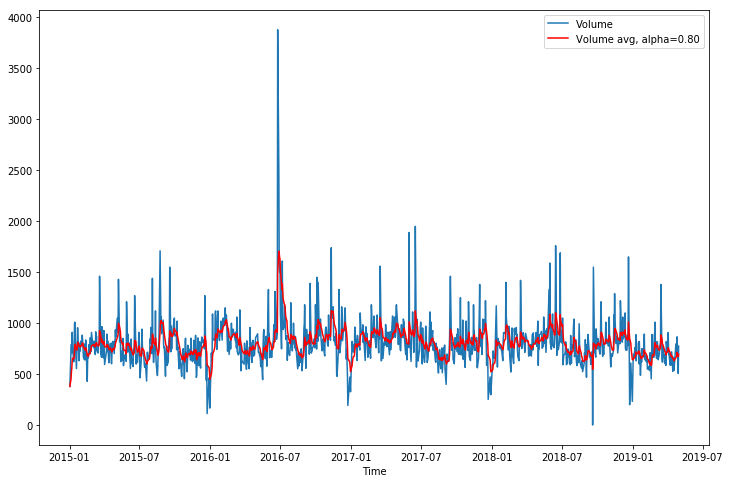

In [49]:
if include_volume:
    index=INPUTS[0]
    print("Plotting %s with alpha=0.8" % index['label'])
    plot_volume(input_df_clean[index['label']], plot_avg=True, alpha=0.8)

Plotting LONDON with alpha=0.9


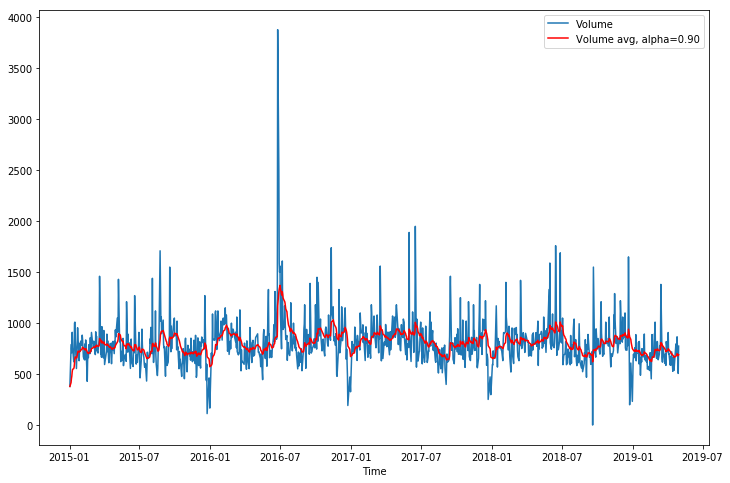

In [50]:
#plot_volume(input_df_clean['DAX'], plot_avg=True, alpha=0.9)
if include_volume:
    print("Plotting %s with alpha=0.9" % index['label'])
    plot_volume(input_df_clean[index['label']], plot_avg=True, alpha=0.9)

Now let's calculate the `Volume average` and `Volume change` for each index, and insert them as new columns in the corresponding dataframe within `input_df_clean`, `target_df_clean` and `target_df_clean`.

In [51]:
if include_volume:
    ALPHA = 0.8
    for key in input_df_clean.keys():
        df = input_df_clean[key]
        df['Vol_avg'] = rolling_average(df.Vol, alpha=ALPHA)
        df['Vol_change'] = df.Vol - df.Vol_avg
        input_df_clean[key] = df
        # Note that volume is given as a single value in the input data.  We create a "Volume Change" feature by finding the
        # difference between that value and the rolling average (An example of feature engineering)
    
        # NOT needed for Target in that we're NOT predicting volume changes
        # 
        # target_df_clean['Vol_avg'] = rolling_average(target_df_clean.Vol, alpha=ALPHA)
        # target_df_clean['Vol_change'] = target_df_clean.Vol - target_df_clean.Vol_avg 


Now, to confirm that the above lines work correctly, let's print out a few lines of each index's dataframe.

In [53]:
if include_volume:
    for key in input_df_clean.keys():
        df = input_df_clean[key]
        print(key)
        print(df.iloc[:5,])
        #print(df.iloc[:,])
        print("-----------")
        print("%s train and validaton/dev" % TARGET['label'])
        print(target_df_clean.iloc[:5,])


LONDON
              Price     Open     High      Low  Change     Vol     Vol_avg  \
2015-01-02  6547.80  6566.09  6607.89  6510.60   -0.28  378.93  378.930000   
2015-01-05  6417.16  6547.80  6576.74  6404.49   -2.00  750.52  453.248000   
2015-01-06  6366.51  6417.16  6452.66  6328.59   -0.79  793.26  521.250400   
2015-01-07  6419.83  6366.51  6459.74  6366.51    0.84  709.50  558.900320   
2015-01-08  6569.96  6419.83  6580.82  6419.83    2.34  910.04  629.128256   

            Vol_change  
2015-01-02    0.000000  
2015-01-05  297.272000  
2015-01-06  272.009600  
2015-01-07  150.599680  
2015-01-08  280.911744  
-----------
NSDQ train and validaton/dev
              Price     Open     High      Low  Change     Vol
2015-01-02  4726.81  4760.24  4777.01  4698.11   -0.20  367.74
2015-01-05  4652.57  4700.34  4702.77  4641.46   -1.57  476.45
2015-01-06  4592.74  4666.85  4667.33  4567.60   -1.29  553.62
2015-01-07  4650.47  4626.84  4652.72  4613.90    1.26  482.51
2015-01-08  4736.1

### Output Vectors for Neural Network

In [54]:
from keras import models
from keras import layers
from keras.callbacks import TensorBoard 

As inputs to the neural net we'd like to use the following 14 float values:
- the price % change of indexes: DAX, FTMIB, FTSE100, MOEX, RTSI, SSMI, TA35. This is one float value for each (7 of them)
- the volume % change (calculated above in "Volume rolling average" section) for the same indexes. Also one float value for each (another 7 - or 14 total)


Now the following few lines concatenate the needed data for the above indexes into a single numpy matrix - suitable for plugging into a neural net.

In [55]:
# First, create a dataframe that contains all features (e.g. Number of symbols X 2 attributes (price change and volume change)
# X 1 attribute (price change) if NOT including volume

df_nn = pd.DataFrame()

for i,key in enumerate(input_df_clean.keys()):
    df = input_df_clean[key]
    df=df[['Change']]
    df.rename(columns={'Change': 'Change_%s' % key}, inplace = True)
    
    if i == 0:
        df_nn = df             # In case it's an empty dataframe
    else:
        df_nn=df_nn.join(df, how='outer')
    
    if include_volume:
        df = input_df_clean[key]
        df=df[['Vol_change']]
        df.rename(columns={'Vol_change': 'Vol_change_%s' % key}, inplace = True)
        df_nn=df_nn.join(df, how='outer')
    
# Concatenate the target (output) price change of TARGET index
# Again, only interested in the price change (of our TARGET)...therefore volume change is not needed
#  Why concat the target - when we're going to write out separate input and target files?  It makes it easy to
#  drop those rows in the inputs where the target dates are zeros...that's why.

df = target_df_clean[ ['Change'] ]
df.rename(columns={'Change': 'Target_change_%s' % TARGET['label']}, inplace = True)
df_nn=df_nn.join(df, how='outer')
    
# print(df_nn)



C:\Anaconda3\lib\site-packages\pandas\core\frame.py:3778: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  return super(DataFrame, self).rename(**kwargs)


The above merging does the correct thing - merging data by the dataframe index (Date). <font color='red'>We can observe some NaN values. These are due to holidays in different countries.</font> For example MOEX index (the Moscow Exchange) and RTSI (Russian Trading index) have NaN values on 7 Jan 2015 because it's Russian Christmas. Let's see how many NaNs are there...

Looking at the target column (`XXXX_price_change`) we can see that there are missing values. The rows with NaN in this column are useless (since we don't have a value for the target), and we need to remove all these lines.

In [56]:
target_priceChange = ('Target_change_%s' % TARGET['label'])

print("There are %d NaN values in %s out of %d." % (sum(df_nn[target_priceChange].isnull() ), TARGET['label'], len(df_nn)) )


There are 63 NaN values in NSDQ out of 1151.


In [57]:
# Drop rows with NaN value in the target column

df_nn = df_nn[np.isfinite(df_nn[target_priceChange])]

# Check NaN values again
print("After: %d NaN values in %s out of %d." % (sum(df_nn[target_priceChange].isnull() ), TARGET['label'], len(df_nn)) )
print("After:  %d real values in %s out of %d." % (sum(np.isfinite(df_nn[target_priceChange])), TARGET['label'], len(df_nn)) )

After: 0 NaN values in NSDQ out of 1088.
After:  1088 real values in NSDQ out of 1088.


For the rest of the NaN values (in input data), we can observe that there are very few missing values in our data, except for the TA35 index (Tel Aviv). If we plot it we can see many periods are just missing data. This might need to be checked in the future. For now, we have two options on what to do with missing values in the input data:
- Replace NaNs with 0s, so that (if having enough of data) the neural net would be able to understand that seeing a value 0 in all these position means "missing data".
- Remove all rows where data is missing. This might not be the best idea as we'll lose a lot of data (NaN values are very frequent in rows).

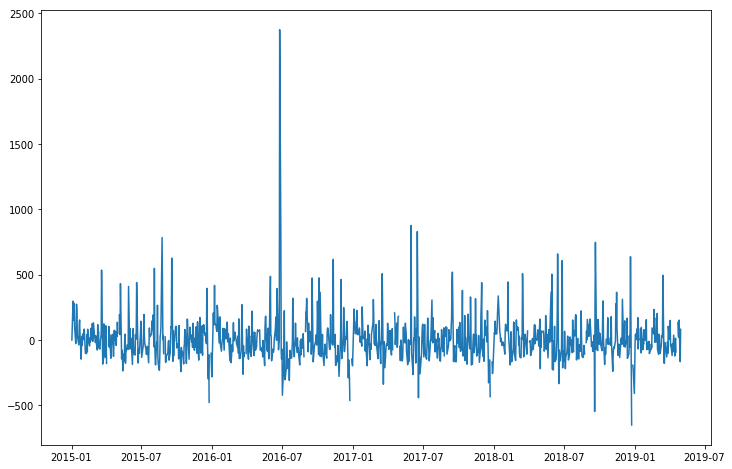

In [58]:
if include_volume:
    Symbol=INPUTS[0]
    test_volume_change= ('Vol_change_%s' % Symbol['label'])

    plt.plot(df_nn[test_volume_change])
    plt.show()

In [59]:
# Print info on the dataframe
df_nn.info()

# Fill in missing input data as 0s
df_nn.fillna(value=0, inplace=True)
df_nn.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1088 entries, 2015-01-02 to 2019-04-30
Data columns (total 5 columns):
Change_LONDON         1071 non-null float64
Vol_change_LONDON     1071 non-null float64
Change_TOKYO          1024 non-null float64
Vol_change_TOKYO      1024 non-null float64
Target_change_NSDQ    1088 non-null float64
dtypes: float64(5)
memory usage: 51.0 KB
<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1088 entries, 2015-01-02 to 2019-04-30
Data columns (total 5 columns):
Change_LONDON         1088 non-null float64
Vol_change_LONDON     1088 non-null float64
Change_TOKYO          1088 non-null float64
Vol_change_TOKYO      1088 non-null float64
Target_change_NSDQ    1088 non-null float64
dtypes: float64(5)
memory usage: 51.0 KB


In [62]:
print(df_nn.columns)

Index(['Change_LONDON', 'Vol_change_LONDON', 'Change_TOKYO',
       'Vol_change_TOKYO', 'Target_change_NSDQ'],
      dtype='object')


Now we're ready to convert our Dataframes into numpy arrays (matrices) and then plug them in a neural net.

In [63]:
targets = df_nn[target_priceChange].values
print("targets type is:  ", type(targets) )
print(targets.shape)

targets type is:   <class 'numpy.ndarray'>
(1088,)


In [64]:
if target_priceChange in df_nn.columns:
    df_nn.drop(target_priceChange, axis=1, inplace=True)
    
inputs = df_nn.values
print(inputs.shape)
print(inputs[0:5])

(1088, 4)
[[-2.80000000e-01  0.00000000e+00  0.00000000e+00  0.00000000e+00]
 [-2.00000000e+00  2.97272000e+02 -2.40000000e-01  0.00000000e+00]
 [-7.90000000e-01  2.72009600e+02 -3.02000000e+00  3.96480000e-02]
 [ 8.40000000e-01  1.50599680e+02  1.00000000e-02  9.75840000e-03]
 [ 2.34000000e+00  2.80911744e+02  1.67000000e+00  9.43872000e-03]]


In [66]:
# Write them out...then read them back in to be sure.

print("Writing out the following INPUT array:  %s" % str(inputs.shape) )
np.save("nn_inputs", inputs)
del inputs
inputs=np.load("nn_inputs" + '.npy')
print("Read Back:  %s" % str(inputs.shape) )

print("Writing out the following TARGET array: %s"  % str(targets.shape))
np.save("nn_targets", targets)
del targets
targets=np.load("nn_targets" + '.npy')
print("Read Back:  %s" % str(targets.shape) )



Writing out the following INPUT array:  (1088, 4)
Read Back:  (1088, 4)
Writing out the following TARGET array: (1088,)
Read Back:  (1088,)


In [67]:
print("Done")

Done
